In [1]:
import numpy as np
import pandas as pd
import random
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer import EM
from scipy.stats import pearsonr

true x0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true f: [0.         0.         0.01086482 0.01926447 0.00799368 0.03305314
 0.02575081 0.0261343  0.01650839 0.        ]
pearson R score vs. time: PearsonRResult(statistic=0.7099768764021956, pvalue=0.49741073377240985)
     patient_id        dt  cognitive_score  beta_true  biomarker_1  \
0             0  0.000000         7.032666   7.367097     0.816240   
1             0  0.303052         8.804347   7.367097     0.836577   
2             0  0.606105         9.905526   7.367097     0.854667   
3             1  0.000000         4.849062   0.130529     0.000057   
4             1  0.443267        -9.645380   0.130529     0.000724   
..          ...       ...              ...        ...          ...   
595         198  1.043221        11.831140   5.598680     0.758458   
596         198  2.086443         5.486597   5.598680     0.836577   
597         199  0.000000        -6.013871   7.379459     0.816240   
598         199  0.428946        34.557

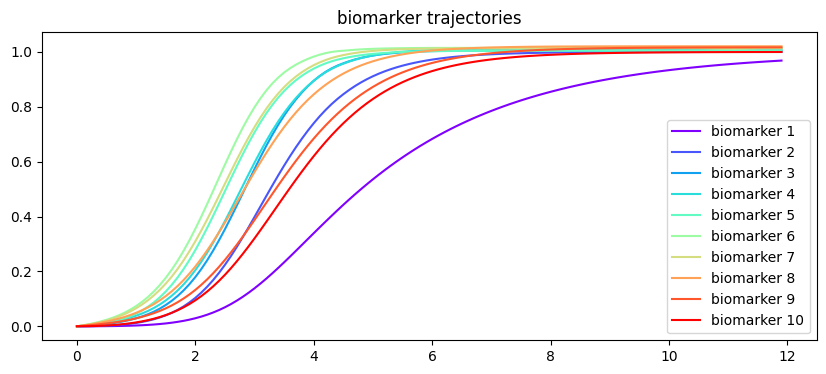

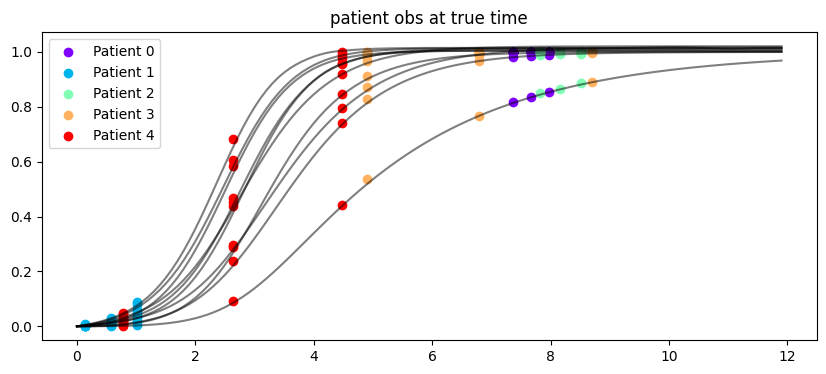

initial conditions:
initial f: [0.12231389 0.01587223 0.05173064 0.08286718 0.11817138 0.15688446
 0.01431301 0.09281749 0.07737243 0.05852591]
initial s: [2.16835773 1.41802286 2.93614619 2.7287357  0.88152634 2.41832018
 0.41724825 2.24422484 2.17132464 0.43775293]
initial scalar: 1.5085580520748387
initial beta estimates (first 5 patients):    patient_id         0
0           0  2.559500
1           0  2.559500
2           0  2.559500
3           1  1.837549
4           1  1.837549
initial beta mean: 6.2177


 92%|█████████▏| 11/12 [00:54<00:04,  4.97s/it]


SUMMARY:
best LSE at iteration 1: 0
initial theta
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.12231389 0.01587223
 0.05173064 0.08286718 0.11817138 0.15688446 0.01431301 0.09281749
 0.07737243 0.05852591 2.16835773 1.41802286 2.93614619 2.7287357
 0.88152634 2.41832018 0.41724825 2.24422484 2.17132464 0.43775293
 1.50855805]
best theta:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.16812341 0.         0.         0.
 0.         0.         0.93069317 0.94271382 0.88263969 0.89308521
 1.00062111 0.91858078 0.9037626  1.00151147 1.01760237 1.02302485
 0.9496721 ]
final theta:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.93398026e-03 1.20309239e-01
 8.17944939e-04 1.31026396e-03 4.22184771e-03 2.48059683e-03
 2.57967914e-03 1

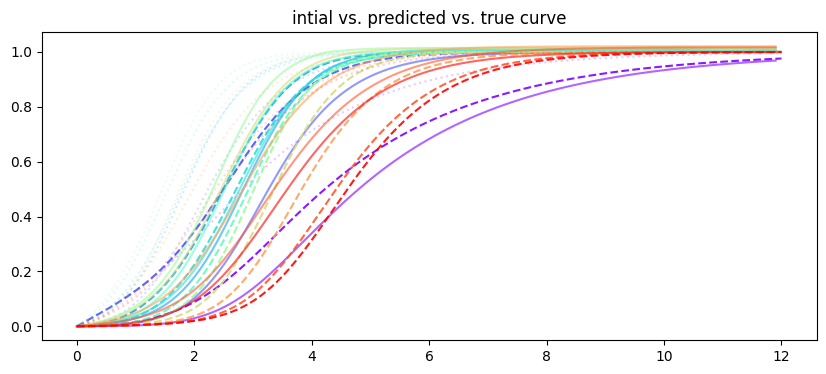

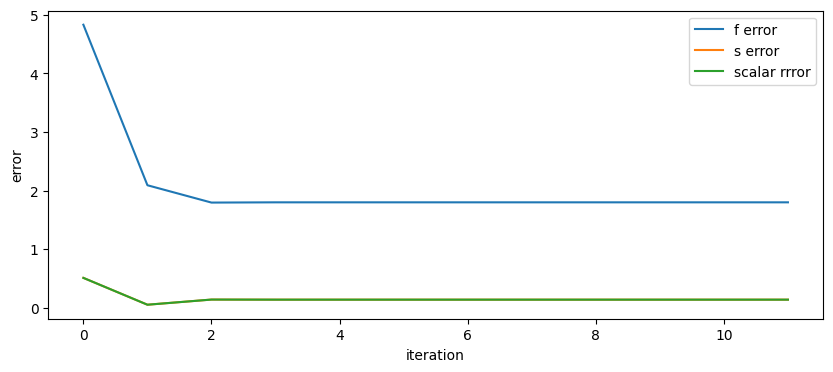

/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:128: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


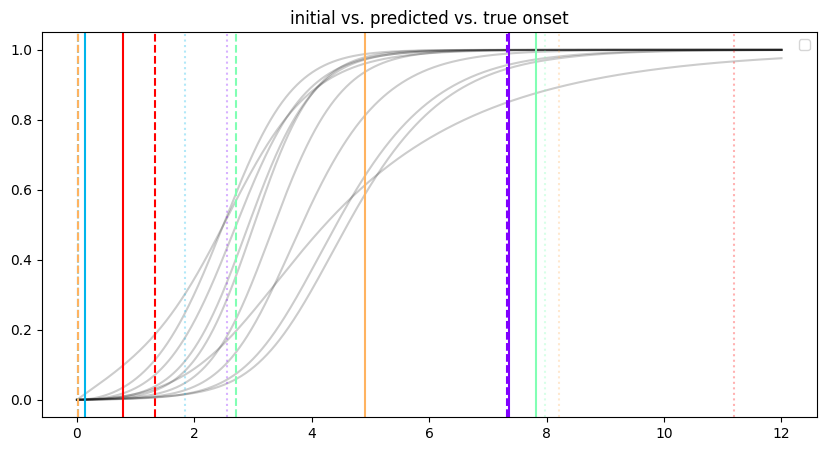

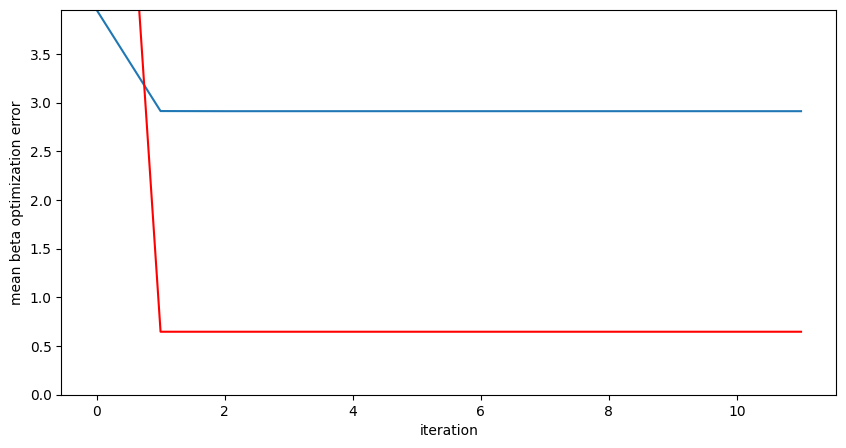

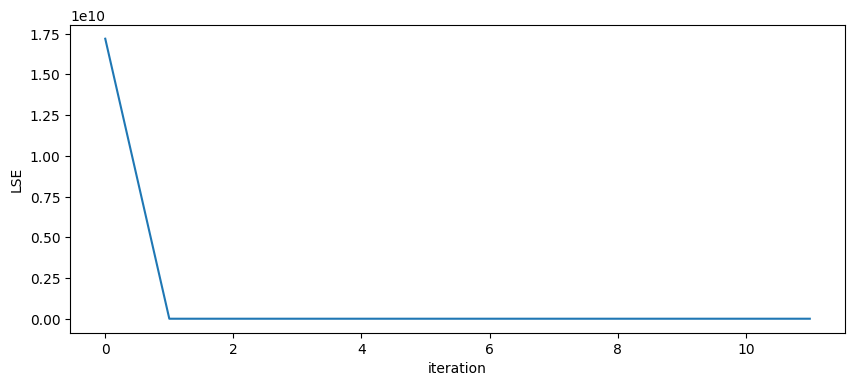

In [2]:
# params
n_biomarkers = 10
t_max = 12
t_span = np.linspace(0, t_max, 2000)
noise_level = 0.0
n_patients = 200
n_patient_obs = 3

# fit and transform
t, x_true, K, x0, f, scalar_K  = generate_logistic_model(n_biomarkers=n_biomarkers, t_max=t_max)

df, beta_true_dict = generate_synthetic_data(
    n_biomarkers = n_biomarkers,
    t_max = t_max, 
    noise_level = noise_level,
    n_patients = n_patients,
    n_patient_obs = n_patient_obs,
    x_true=x_true, 
    t=t,
)

print(df)

plot_biomarker_trajectories(t, x_true, n_biomarkers=n_biomarkers)
plot_true_observations(df, t, x_true)

em_model_0 = EM(K=K,
              num_iterations=12,
              t_max=t_max,
              step=0.01,
              use_jacobian=True,
              lambda_cog=1.0,
              )

em_model_0.fit(df)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# final parameters
theta_final = em_model_0.theta_iter_[f"iter_{em_model_0.num_iterations - 1}"].values
x0_final = theta_final[:n_biomarkers]
f_final = theta_final[n_biomarkers:2*n_biomarkers]
x_final = solve_system(x0_final, f_final, K, t_span)

# initial parameters
theta_init = em_model_0.theta_iter_["iter_0"].values
x0_init = theta_init[:n_biomarkers]
f_init = theta_init[n_biomarkers:2*n_biomarkers]
x_init = solve_system(x0_init, f_init, K, t_span)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, x_init, x_final, n_biomarkers)
plot_theta_error_history(
    theta_iter=em_model_0.theta_iter_,
    n_biomarkers=n_biomarkers,
    num_iterations=em_model_0.num_iterations,
    f_true=f,
    s_true=np.ones(n_biomarkers),
    scalar_K_true=scalar_K
)
plot_beta_overlay(df, em_model_0.beta_iter_, em_model_0.theta_iter_, t_span, n_biomarkers, x_init, x_final, iteration=em_model_0.num_iterations - 1)
plot_beta_error_history(em_model_0.beta_iter_, em_model_0.alpha_iter_, df, em_model_0.num_iterations)
plot_lse(em_model_0.lse_array_)


## cog = 0.01

initial conditions:
initial f: [0.01490907 0.16291554 0.08029182 0.184533   0.15572293 0.19792942
 0.02388094 0.10736655 0.1746095  0.11053824]
initial s: [1.25802863 0.88057217 1.69412896 2.02240196 1.29799371 2.24293252
 0.44400018 2.17350915 0.34762954 1.64389975]
initial scalar: 2.789092063970113
initial beta estimates (first 5 patients):    patient_id         0
0           0  2.559500
1           0  2.559500
2           0  2.559500
3           1  1.837549
4           1  1.837549
initial beta mean: 6.2177


 92%|█████████▏| 11/12 [02:46<00:15, 15.13s/it]


SUMMARY:
best LSE at iteration 8: 640.5215253282975
initial theta
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01490907 0.16291554
 0.08029182 0.184533   0.15572293 0.19792942 0.02388094 0.10736655
 0.1746095  0.11053824 1.25802863 0.88057217 1.69412896 2.02240196
 1.29799371 2.24293252 0.44400018 2.17350915 0.34762954 1.64389975
 2.78909206]
best theta:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.08349272e-01 0.00000000e+00
 0.00000000e+00 4.04906311e-05 5.01037597e-04 4.87723983e-04
 4.84968627e-04 1.25344778e-04 6.59240390e-03 1.66433450e-04
 3.77641523e-01 1.14461030e+00 1.17906801e+00 1.20753744e+00
 1.02147893e+00 1.02733062e+00 1.04008483e+00 1.18679221e+00
 1.13795468e+00 1.10815438e+00 4.43772160e-01]
final theta:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.

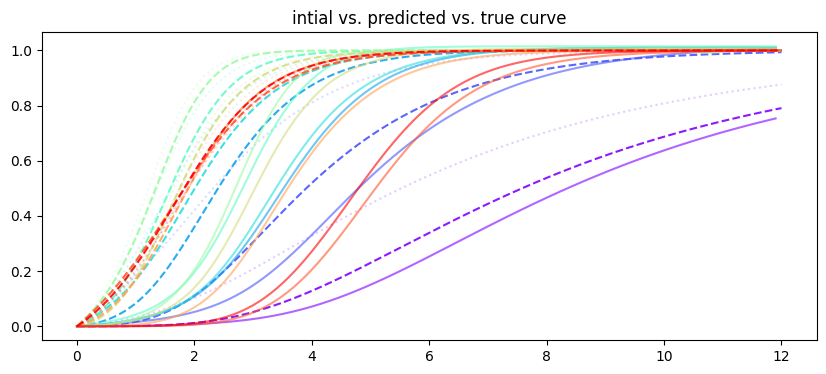

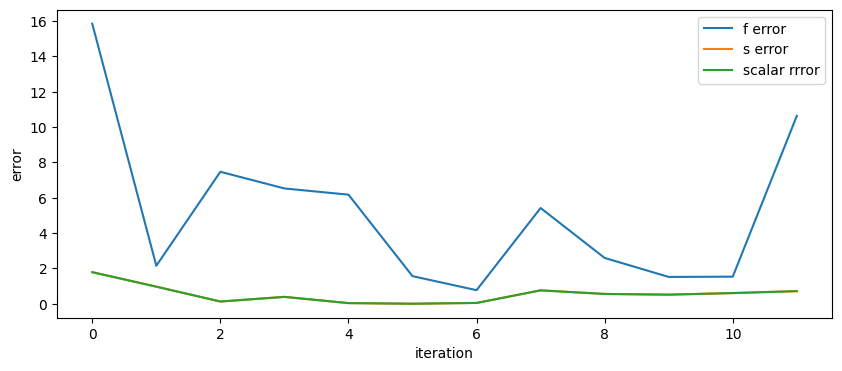

/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:128: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


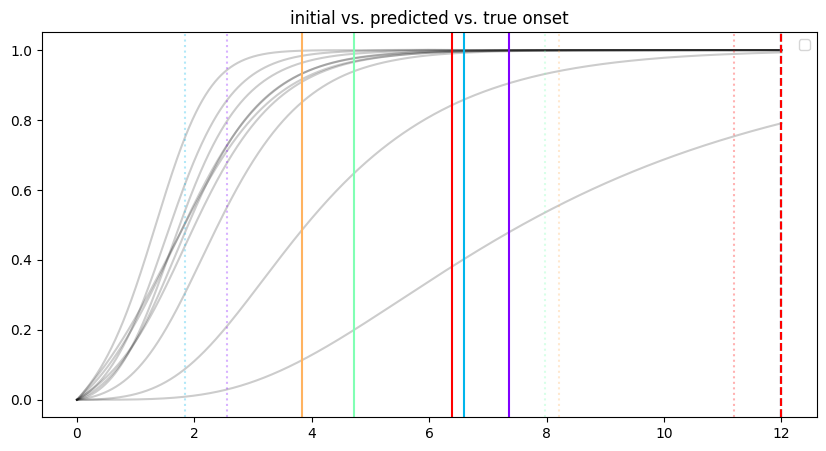

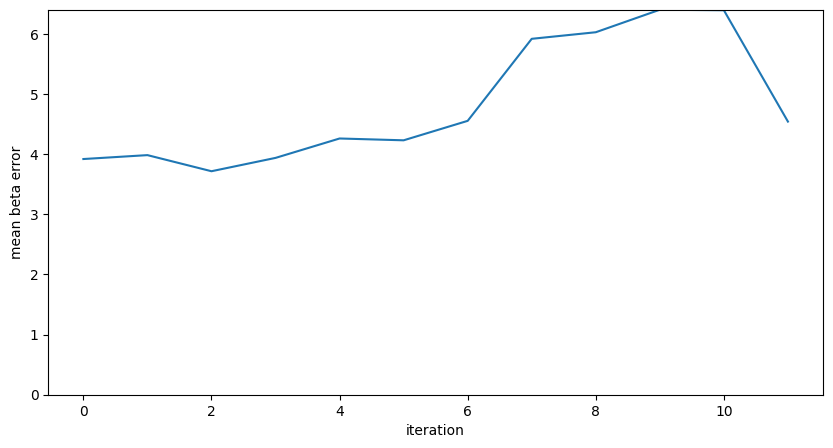

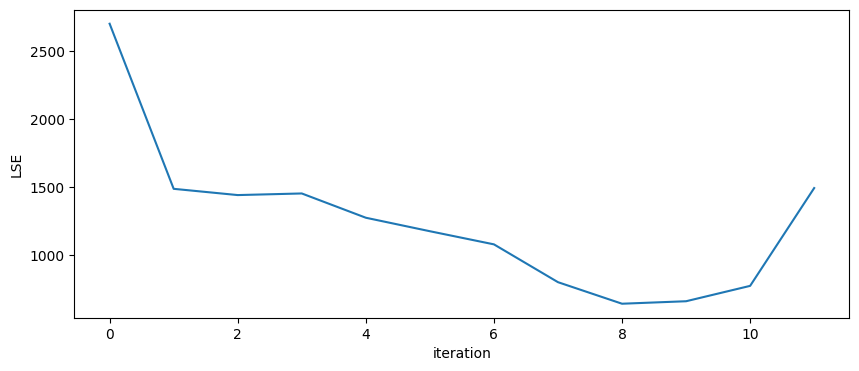

In [5]:
em_model_0 = EM(K=K,
              num_iterations=12,
              t_max=t_max,
              step=0.01,
              use_jacobian=True,
              lambda_cog=0.01,
              )

em_model_0.fit(df)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# final parameters
theta_final = em_model_0.theta_iter_[f"iter_{em_model_0.num_iterations - 1}"].values
x0_final = theta_final[:n_biomarkers]
f_final = theta_final[n_biomarkers:2*n_biomarkers]
x_final = solve_system(x0_final, f_final, K, t_span)

# initial parameters
theta_init = em_model_0.theta_iter_["iter_0"].values
x0_init = theta_init[:n_biomarkers]
f_init = theta_init[n_biomarkers:2*n_biomarkers]
x_init = solve_system(x0_init, f_init, K, t_span)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, x_init, x_final, n_biomarkers)
plot_theta_error_history(
    theta_iter=em_model_0.theta_iter_,
    n_biomarkers=n_biomarkers,
    num_iterations=em_model_0.num_iterations,
    f_true=f,
    s_true=np.ones(n_biomarkers),
    scalar_K_true=scalar_K
)
plot_beta_overlay(df, em_model_0.beta_iter_, em_model_0.theta_iter_, t_span, n_biomarkers, x_init, x_final, iteration=em_model_0.num_iterations - 1)
plot_beta_error_history(em_model_0.beta_iter_, df, em_model_0.num_iterations)
plot_lse(em_model_0.lse_array_)


## cog = 0.1

initial conditions:
initial f: [0.01490907 0.16291554 0.08029182 0.184533   0.15572293 0.19792942
 0.02388094 0.10736655 0.1746095  0.11053824]
initial s: [1.25802863 0.88057217 1.69412896 2.02240196 1.29799371 2.24293252
 0.44400018 2.17350915 0.34762954 1.64389975]
initial scalar: 2.789092063970113
initial beta estimates (first 5 patients):    patient_id         0
0           0  2.559500
1           0  2.559500
2           0  2.559500
3           1  1.837549
4           1  1.837549
initial beta mean: 6.2177


 92%|█████████▏| 11/12 [00:18<00:01,  1.64s/it]


SUMMARY:
best LSE at iteration 10: 2809.197273254881
initial theta
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01490907 0.16291554
 0.08029182 0.184533   0.15572293 0.19792942 0.02388094 0.10736655
 0.1746095  0.11053824 1.25802863 0.88057217 1.69412896 2.02240196
 1.29799371 2.24293252 0.44400018 2.17350915 0.34762954 1.64389975
 2.78909206]
best theta:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.29880804e-02
 1.89702340e-03 3.08778223e-16 3.27156493e-02 3.51112230e-16
 1.45750226e-16 2.79513071e-16 0.00000000e+00 1.66557814e-16
 2.89885996e-01 5.99073512e-01 7.58998121e-01 7.70176749e-01
 8.36510071e-01 8.44741182e-01 8.11388522e-01 7.42594576e-01
 5.82601749e-01 6.18184225e-01 1.84196262e+00]
final theta:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0

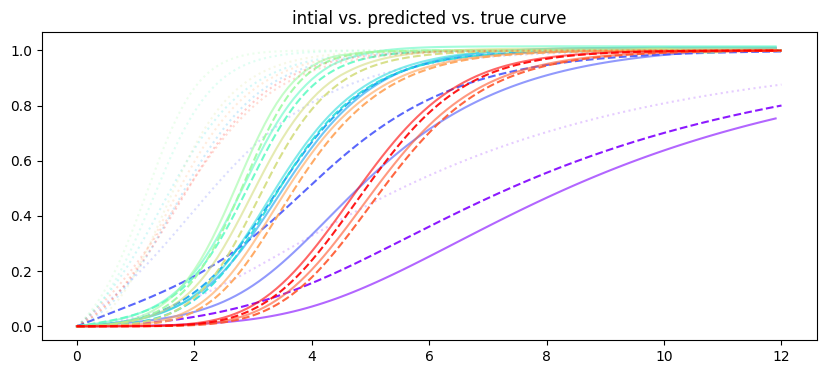

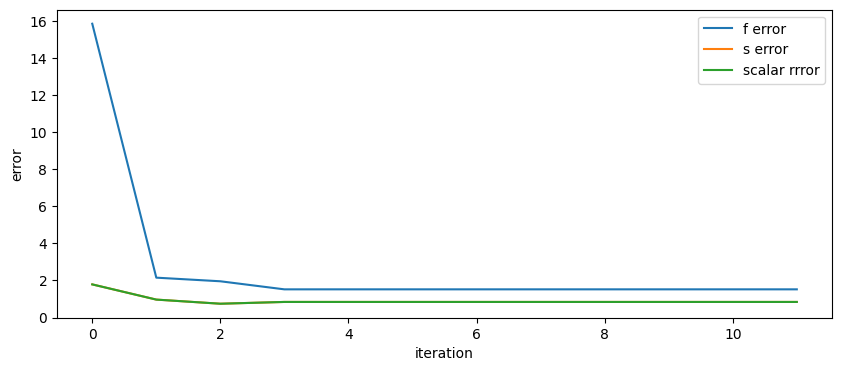

/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:128: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


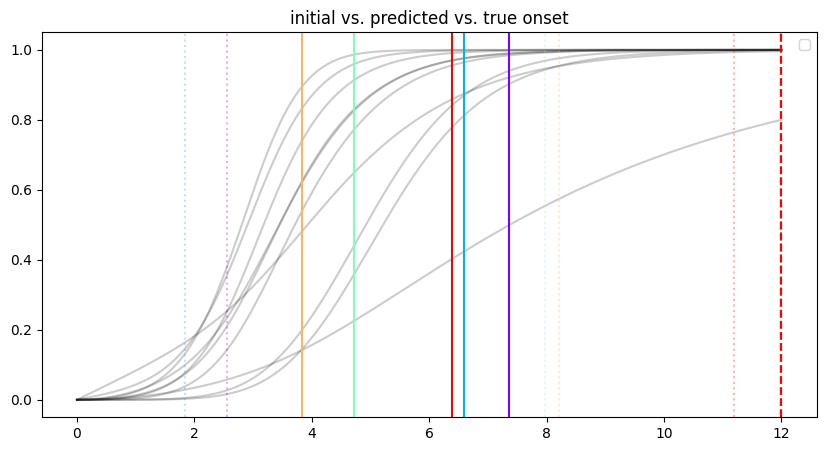

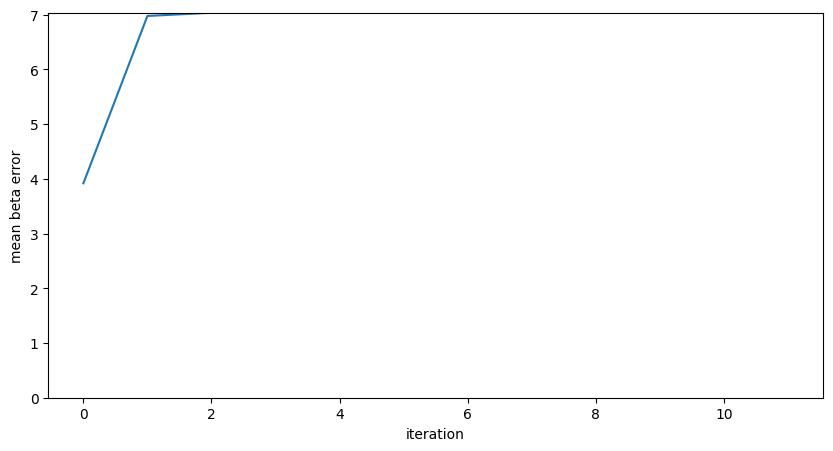

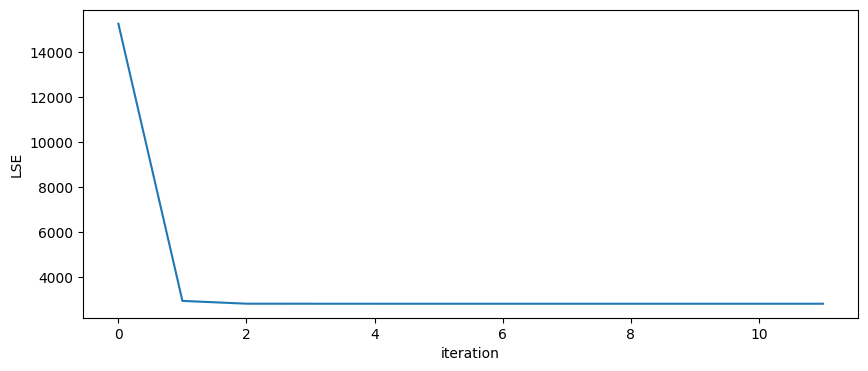

In [6]:
em_model_0 = EM(K=K,
              num_iterations=12,
              t_max=t_max,
              step=0.01,
              use_jacobian=True,
              lambda_cog=0.1,
              )

em_model_0.fit(df)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# final parameters
theta_final = em_model_0.theta_iter_[f"iter_{em_model_0.num_iterations - 1}"].values
x0_final = theta_final[:n_biomarkers]
f_final = theta_final[n_biomarkers:2*n_biomarkers]
x_final = solve_system(x0_final, f_final, K, t_span)

# initial parameters
theta_init = em_model_0.theta_iter_["iter_0"].values
x0_init = theta_init[:n_biomarkers]
f_init = theta_init[n_biomarkers:2*n_biomarkers]
x_init = solve_system(x0_init, f_init, K, t_span)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, x_init, x_final, n_biomarkers)
plot_theta_error_history(
    theta_iter=em_model_0.theta_iter_,
    n_biomarkers=n_biomarkers,
    num_iterations=em_model_0.num_iterations,
    f_true=f,
    s_true=np.ones(n_biomarkers),
    scalar_K_true=scalar_K
)
plot_beta_overlay(df, em_model_0.beta_iter_, em_model_0.theta_iter_, t_span, n_biomarkers, x_init, x_final, iteration=em_model_0.num_iterations - 1)
plot_beta_error_history(em_model_0.beta_iter_, df, em_model_0.num_iterations)
plot_lse(em_model_0.lse_array_)


## cog = 1.0

initial conditions:
initial f: [0.01490907 0.16291554 0.08029182 0.184533   0.15572293 0.19792942
 0.02388094 0.10736655 0.1746095  0.11053824]
initial s: [1.25802863 0.88057217 1.69412896 2.02240196 1.29799371 2.24293252
 0.44400018 2.17350915 0.34762954 1.64389975]
initial scalar: 2.789092063970113
initial beta estimates (first 5 patients):    patient_id         0
0           0  2.559500
1           0  2.559500
2           0  2.559500
3           1  1.837549
4           1  1.837549
initial beta mean: 6.2177


 92%|█████████▏| 11/12 [00:12<00:01,  1.17s/it]


SUMMARY:
best LSE at iteration 7: 12412.179182882832
initial theta
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01490907 0.16291554
 0.08029182 0.184533   0.15572293 0.19792942 0.02388094 0.10736655
 0.1746095  0.11053824 1.25802863 0.88057217 1.69412896 2.02240196
 1.29799371 2.24293252 0.44400018 2.17350915 0.34762954 1.64389975
 2.78909206]
best theta:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.09182459
 0.04840189 0.11992044 0.10071538 0.19743401 0.0216956  0.07086946
 0.18305251 0.14024246 0.27685721 0.59501321 0.75623125 0.7679186
 0.83418522 0.84480907 0.80806058 0.74012794 0.57463452 0.61325084
 1.83812743]
final theta:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.09182591
 0.04840616 0.11992545 0.10071738 0.19743404 0.0216956  0.07087527
 0.1830568  0.14024804 0.2768571  0

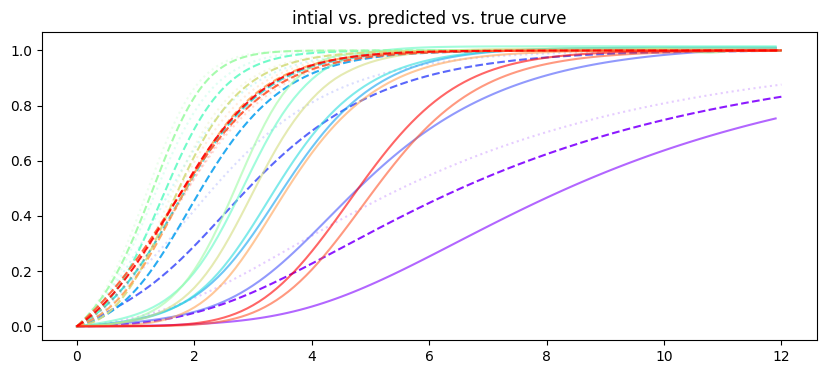

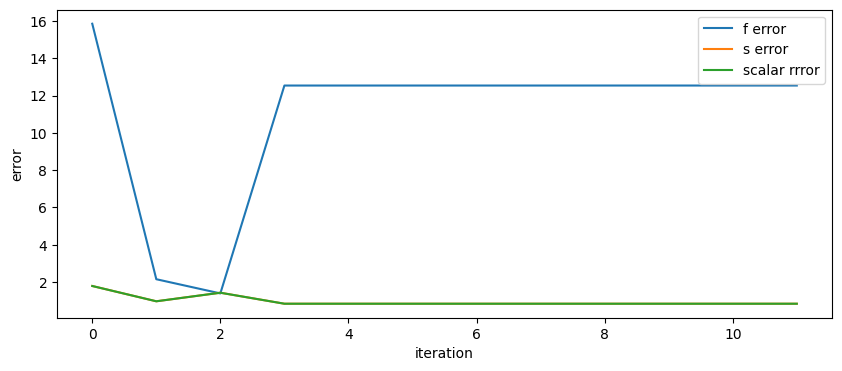

/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:128: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


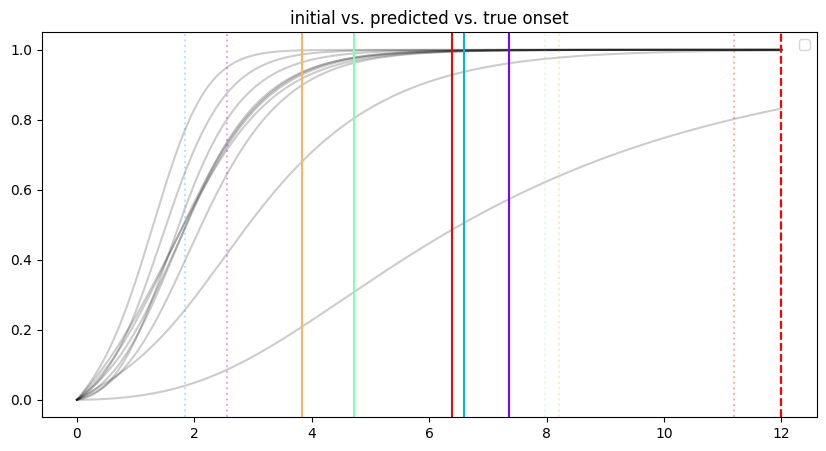

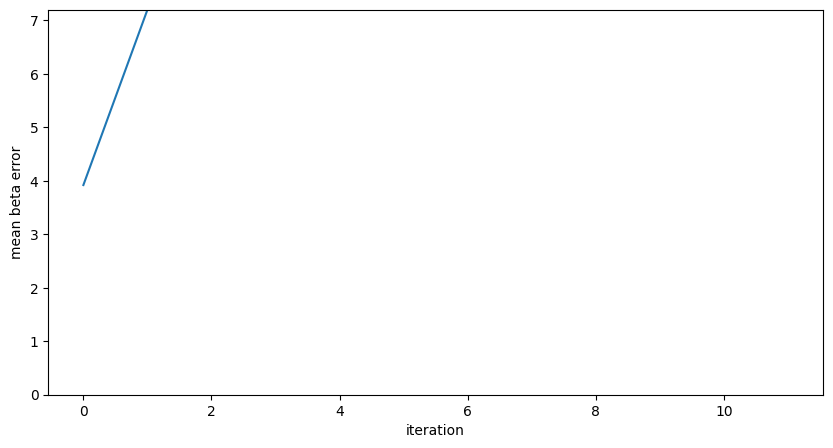

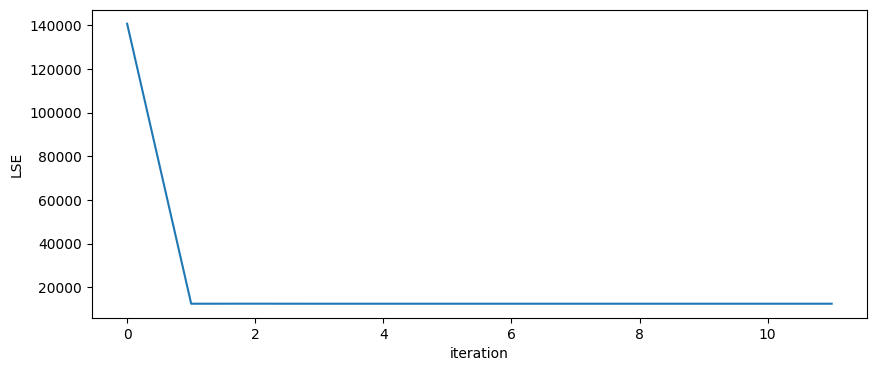

In [7]:
em_model_0 = EM(K=K,
              num_iterations=12,
              t_max=t_max,
              step=0.01,
              use_jacobian=True,
              lambda_cog=1.0,
              )

em_model_0.fit(df)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# final parameters
theta_final = em_model_0.theta_iter_[f"iter_{em_model_0.num_iterations - 1}"].values
x0_final = theta_final[:n_biomarkers]
f_final = theta_final[n_biomarkers:2*n_biomarkers]
x_final = solve_system(x0_final, f_final, K, t_span)

# initial parameters
theta_init = em_model_0.theta_iter_["iter_0"].values
x0_init = theta_init[:n_biomarkers]
f_init = theta_init[n_biomarkers:2*n_biomarkers]
x_init = solve_system(x0_init, f_init, K, t_span)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, x_init, x_final, n_biomarkers)
plot_theta_error_history(
    theta_iter=em_model_0.theta_iter_,
    n_biomarkers=n_biomarkers,
    num_iterations=em_model_0.num_iterations,
    f_true=f,
    s_true=np.ones(n_biomarkers),
    scalar_K_true=scalar_K
)
plot_beta_overlay(df, em_model_0.beta_iter_, em_model_0.theta_iter_, t_span, n_biomarkers, x_init, x_final, iteration=em_model_0.num_iterations - 1)
plot_beta_error_history(em_model_0.beta_iter_, df, em_model_0.num_iterations)
plot_lse(em_model_0.lse_array_)


## cog = 1.0

initial conditions:
initial f: [0.01490907 0.16291554 0.08029182 0.184533   0.15572293 0.19792942
 0.02388094 0.10736655 0.1746095  0.11053824]
initial s: [1.25802863 0.88057217 1.69412896 2.02240196 1.29799371 2.24293252
 0.44400018 2.17350915 0.34762954 1.64389975]
initial scalar: 2.789092063970113
initial beta estimates (first 5 patients):    patient_id         0
0           0  2.559500
1           0  2.559500
2           0  2.559500
3           1  1.837549
4           1  1.837549
initial beta mean: 6.2177


 92%|█████████▏| 11/12 [00:12<00:01,  1.15s/it]


SUMMARY:
best LSE at iteration 10: 111525.04442149447
initial theta
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01490907 0.16291554
 0.08029182 0.184533   0.15572293 0.19792942 0.02388094 0.10736655
 0.1746095  0.11053824 1.25802863 0.88057217 1.69412896 2.02240196
 1.29799371 2.24293252 0.44400018 2.17350915 0.34762954 1.64389975
 2.78909206]
best theta:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.09182337
 0.04840393 0.11991761 0.10071542 0.19743197 0.02169231 0.07087274
 0.18305438 0.14024561 0.27685709 0.5950132  0.75623125 0.76791859
 0.83418521 0.84480907 0.80806057 0.74012794 0.57463451 0.61325084
 1.83812855]
final theta:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.09182711
 0.04839998 0.11992158 0.10071886 0.1974364  0.02169547 0.07087524
 0.18305256 0.14024709 0.27685696

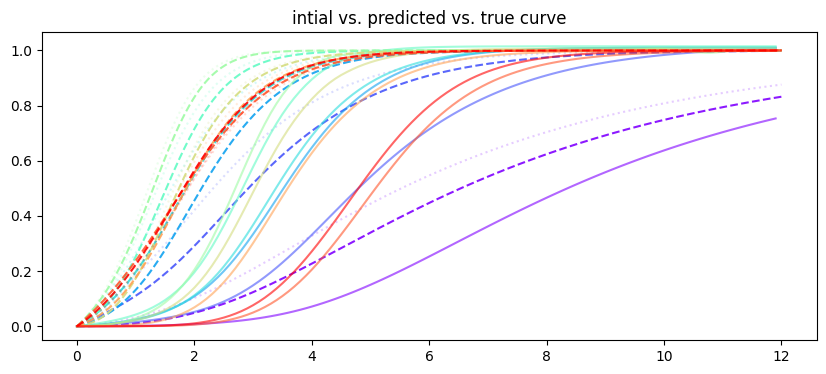

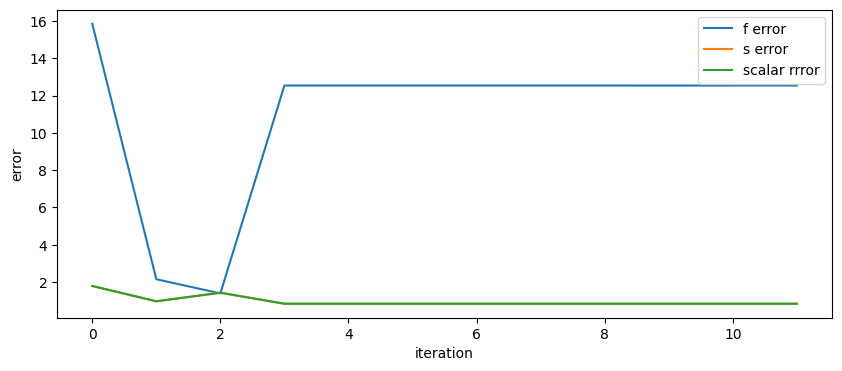

/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:128: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


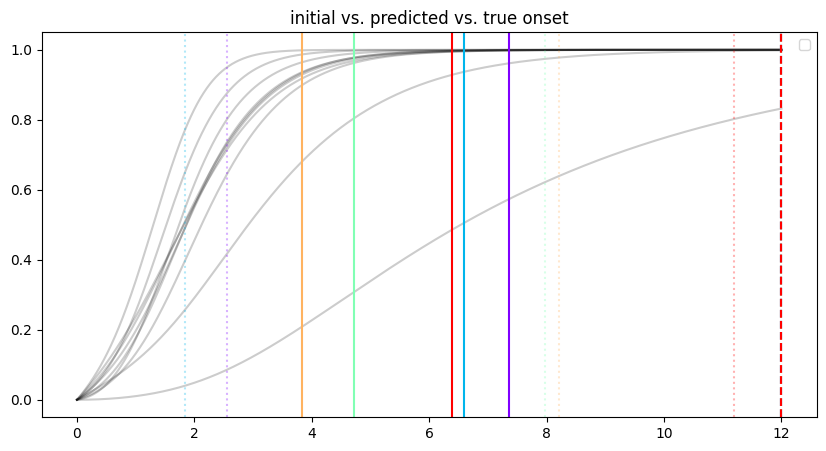

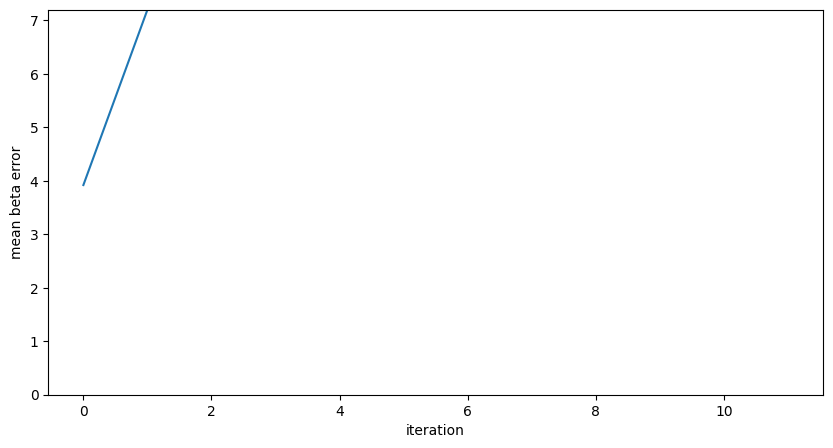

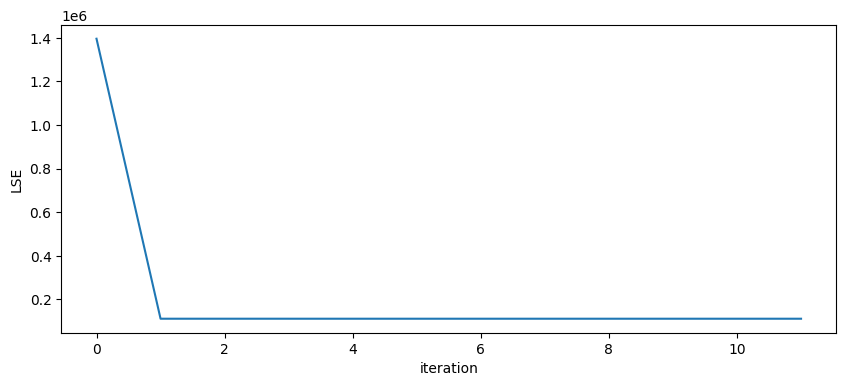

In [8]:
em_model_0 = EM(K=K,
              num_iterations=12,
              t_max=t_max,
              step=0.01,
              use_jacobian=True,
              lambda_cog=10.0,
              )

em_model_0.fit(df)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# final parameters
theta_final = em_model_0.theta_iter_[f"iter_{em_model_0.num_iterations - 1}"].values
x0_final = theta_final[:n_biomarkers]
f_final = theta_final[n_biomarkers:2*n_biomarkers]
x_final = solve_system(x0_final, f_final, K, t_span)

# initial parameters
theta_init = em_model_0.theta_iter_["iter_0"].values
x0_init = theta_init[:n_biomarkers]
f_init = theta_init[n_biomarkers:2*n_biomarkers]
x_init = solve_system(x0_init, f_init, K, t_span)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, x_init, x_final, n_biomarkers)
plot_theta_error_history(
    theta_iter=em_model_0.theta_iter_,
    n_biomarkers=n_biomarkers,
    num_iterations=em_model_0.num_iterations,
    f_true=f,
    s_true=np.ones(n_biomarkers),
    scalar_K_true=scalar_K
)
plot_beta_overlay(df, em_model_0.beta_iter_, em_model_0.theta_iter_, t_span, n_biomarkers, x_init, x_final, iteration=em_model_0.num_iterations - 1)
plot_beta_error_history(em_model_0.beta_iter_, df, em_model_0.num_iterations)
plot_lse(em_model_0.lse_array_)
